In [1]:
# Imports
import numpy as np
import pandas as pd
import csv
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import matplotlib.pyplot as plt

np.random.seed(42)


Using TensorFlow backend.


In [2]:
class soc_nn:
    def __init__(self, data, layer_size, no_nodes, no_epochs, batch, opt):
        self.x_train = data[0]
        self.y_train = data[1]
        self.x_test = data[2]
        self.y_test = data[3]
        self.batch_size = batch
        self.number_of_nodes = no_nodes
        self.layer_size = layer_size
        self.optimizer = opt
        self.number_of_epochs = no_epochs

    def run(self):
        # Building the model
        model = Sequential()
        model.add(Dense(len(self.x_train[0]), input_dim=len(self.x_train[0])))
        if self.layer_size >= 1:
            model.add(Dense(self.number_of_nodes[0], activation='relu'))
        if self.layer_size >= 2:
            model.add(Dense(self.number_of_nodes[1], activation='relu'))
        if self.layer_size >= 3:
            model.add(Dense(self.number_of_nodes[2], activation='relu'))

        model.add(Dense(1, activation='sigmoid'))

        # Compiling the model
        model.compile(loss='mean_absolute_error', optimizer=self.optimizer, metrics=['accuracy'])
        # model.summary()

        # Training the model
        model.fit(self.x_train, self.y_train, epochs=self.number_of_epochs, validation_data=(self.x_test, self.y_test),
                  batch_size=self.batch_size, verbose=0)

        return model


def scale_between_0_and_1(df, label):
    if min(df[label]) >= 0:
        return df[label] / max(df[label])
    else:
        return (df[label] + abs(min(df[label]))) / (max(df[label]) + abs(min(df[label])))


def scale_between_minus1_and_1(df, label):
    if abs(min(df[label])) <= max(df[label]):
        df[label] /= max(df[label])
    else:
        df[label] /= abs(min(df[label]))
    return df[label]


def normalize_data(df):
    # creating a list of dataframe columns
    columns = list(df)
    for i in columns:
        if i == 'I_m':
            df[i] = scale_between_minus1_and_1(df, i)
        elif i == 'mode' or i == 'B_E' or i == 'date':
            pass
        else:
            df[i] = scale_between_0_and_1(df, i)
    return df


def optimizer():
    # Optimizer
    # adam = optimizers.Adam(lr=0.0001)
    adadelta = optimizers.Adadelta(lr=1.0, rho=0.95)
    # rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9)
    return [adadelta]


def data_prep(data1, data2):
    # Prepare usable input parameters
    data1['I_m'] = round(data1['mode'] * data1['B_E'] * data1['I_m'], 3)
    data2['I_m'] = round(data2['mode'] * data2['B_E'] * data2['I_m'], 3)
    y_d1 = scale_between_0_and_1(data1, 'SoC')
    y_d2 = scale_between_0_and_1(data2, 'SoC')
    x = []
    y = [y_d1, y_d2]
    label = []
    for data in [data1, data2]:
        # sample_id, actual_time, mode, B_E, I_m, U_b, T_1, T_2, T_3, delta_time, runtime, dV, dV2, dV3, C
        label.append('sample_id-actual_time-mode-B_E-I_m-U_b-T_1-T_2-T_3-delta_time-runtime-dV-dV2-dV3-C')
        x_15p = data.drop(['date', 'SoC'], axis=1)
        x_15p = normalize_data(x_15p)

        # I_m, U_b, T_2, delta_time, runtime, dV, dV2, dV3, C
        label.append('I_m-U_b-T_2-delta_time-runtime-dV-dV2-dV3-C')
        x_9p = data.drop(['sample_id', 'date', 'actual_time', 'mode', 'B_E', 'T_1', 'T_3', 'SoC'], axis=1)
        x_9p = normalize_data(x_9p)

        # I_m, U_b, dV, dV2, dV3, C
        label.append('I_m-U_b-dV-dV2-dV3-C')
        x_6p = data.drop(['sample_id', 'date', 'actual_time', 'mode', 'B_E',
                          'T_1', 'T_2', 'T_3', 'delta_time', 'runtime', 'SoC'], axis=1)
        x_6p = normalize_data(x_6p)

        # I_m, U_b, delta_time, runtime, dV
        label.append('I_m-U_b-delta_time-runtime-dV')
        x_5p_1 = data.drop(['sample_id', 'date', 'actual_time', 'mode', 'B_E', 'T_1', 'T_2', 'T_3', 'dV2', 'dV3', 'C',
                            'SoC'], axis=1)
        x_5p_1 = normalize_data(x_5p_1)

        # I_m, U_b, dV, dV2, dV3
        label.append('I_m-U_b-dV-dV2-dV3')
        x_5p_2 = data.drop(['sample_id', 'date', 'actual_time', 'mode', 'B_E',
                            'T_1', 'T_2', 'T_3', 'delta_time', 'runtime', 'C', 'SoC'], axis=1)
        x_5p_2 = normalize_data(x_5p_2)

        # I_m, U_b, delta_time
        label.append('I_m-U_b-delta_time')
        x_3p = data.drop(['sample_id', 'runtime', 'dV', 'date', 'actual_time', 'mode', 'B_E', 'T_1', 'T_2', 'T_3',
                          'dV2', 'dV3', 'C', 'SoC'], axis=1)
        x_3p = normalize_data(x_3p)

        # I_m, U_b, dV, dV2, dV3, C divided into 3 column groups based on charging mode of the battery
        # x_load has 18 parameters
        # Divide measurements based on charging load profile
        label.append('I_m(3)-U_b(3)-dV(3)-dV2(3)-dV3(3)-C(3)')
        x_load = pd.DataFrame()

        x_load['ch1'] = x_6p['U_b']
        x_load['ch2'] = x_6p['dV']
        x_load['ch3'] = x_6p['dV2']
        x_load['ch4'] = x_6p['dV3']
        x_load['ch5'] = x_6p['C']
        x_load['ch6'] = x_6p['I_m']

        x_load['idle1'] = x_6p['U_b']
        x_load['idle2'] = x_6p['dV']
        x_load['idle3'] = x_6p['dV2']
        x_load['idle4'] = x_6p['dV3']
        x_load['idle5'] = x_6p['C']
        x_load['idle6'] = x_6p['I_m']

        x_load['dsch1'] = x_6p['U_b']
        x_load['dsch2'] = x_6p['dV']
        x_load['dsch3'] = x_6p['dV2']
        x_load['dsch4'] = x_6p['dV3']
        x_load['dsch5'] = x_6p['C']
        x_load['dsch6'] = x_6p['I_m']

        # Clear-up
        # 1st third of the inputs to represent charging 'ch'
        # 2nd third of the inputs to represent Standby or Bypass 'idle'
        # 3rd third of the inputs to represent discharging 'dsch'
        x_load['ch1'].values[x_6p['I_m'] <= 0] = 0
        x_load['ch2'].values[x_6p['I_m'] <= 0] = 0
        x_load['ch3'].values[x_6p['I_m'] <= 0] = 0
        x_load['ch4'].values[x_6p['I_m'] <= 0] = 0
        x_load['ch5'].values[x_6p['I_m'] <= 0] = 0
        x_load['ch6'].values[x_6p['I_m'] <= 0] = 0
        x_load['idle1'].values[x_6p['I_m'] != 0] = 0
        x_load['idle2'].values[x_6p['I_m'] != 0] = 0
        x_load['idle3'].values[x_6p['I_m'] != 0] = 0
        x_load['idle4'].values[x_6p['I_m'] != 0] = 0
        x_load['idle5'].values[x_6p['I_m'] != 0] = 0
        x_load['idle6'].values[x_6p['I_m'] != 0] = 0
        x_load['dsch1'].values[x_6p['I_m'] >= 0] = 0
        x_load['dsch2'].values[x_6p['I_m'] >= 0] = 0
        x_load['dsch3'].values[x_6p['I_m'] >= 0] = 0
        x_load['dsch4'].values[x_6p['I_m'] >= 0] = 0
        x_load['dsch5'].values[x_6p['I_m'] >= 0] = 0
        x_load['dsch6'].values[x_6p['I_m'] >= 0] = 0

        # I_m, U_b, dV, dV2, dV3 divided into 3 column groups based on charging mode of the battery
        # x_load_2 has 15 parameters
        label.append('I_m(3)-U_b(3)-dV(3)-dV2(3)-dV3(3)')
        x_load_2 = x_load.drop(['ch5', 'idle5', 'dsch5'], axis=1)

        # x.append([x_15p, x_9p, x_5p_1, x_5p_2, x_3p, x_6p, x_load, x_load_2])
        x.append([x_load, x_load_2])

    data_sets = []

    for i in range(len(x)):
        for j in range(len(x[i])):
            x_train, y_train = x[i][j].to_numpy(), y[i].to_numpy()
            x_test, y_test = x[1 - i][j].to_numpy(), y[1 - i].to_numpy()
            data_sets.append([x_train, y_train, x_test, y_test])

    return data_sets, label


def plot_run(error, reference, prediction, label):
    plt.subplots(figsize=(15, 18))
    #
    plt.subplot(3, 1, 1)
    plt.title('neuralnet_id: ' + label.split('_')[0])
    plt.plot(reference, label='Reference SoC')
    plt.plot(prediction, label='Prediction SoC')
    plt.xlabel('sample_id')
    plt.ylabel('SoC')
    plt.grid(True)
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title('Error function')
    plt.plot(error, label='Error in SoC prediction')
    plt.xlabel('sample_id')
    plt.ylabel('Error = |y_ref - y_pred|')
    plt.grid(True)
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title('Accuracy')
    plt.plot(1 - error, label='Accuracy id_' + label.split('_')[0] + '')
    plt.xlabel('sample_id')
    plt.ylabel('Accuracy = 1 - |y_ref - y_pred|')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('data/plot/' + label.split('_')[0] + '.png')
    # plt.show()


def plot_trend(error, std, accuracy, label):
    plt.subplots(figsize=(15, 18))
    #
    plt.subplot(3, 1, 1)
    plt.title('Error functions')
    plt.plot(error, label='Error in SoC predictions')
    plt.xlabel('neuralnet_id')
    plt.ylabel('Error = |y_ref - y_pred|')
    plt.grid(True)
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title('Error function standard deviation')
    plt.plot(std, label='Error STD in SoC predictions')
    plt.xlabel('neuralnet_id')
    plt.ylabel('sigma')
    plt.grid(True)
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title('Accuracy')
    plt.plot(accuracy, label='Accuracy of predictions')
    plt.xlabel('neuralnet_id')
    plt.ylabel('Accuracy = 1 - |y_ref - y_pred|')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('data/plot/trend/' + label + '_trend.png')
    # plt.show()


In [3]:
# Load the dataset
data_1 = pd.read_csv('data/Augmented_data/battery_data_1_dV-C-roundV.csv')
print("battery_data_1 has {} data points with {} variables each."
      .format(*data_1.shape))
data_2 = pd.read_csv('data/Augmented_data/battery_data_2_dV-C-roundV.csv')
print("battery_data_2 has {} data points with {} variables each."
      .format(*data_2.shape))

data_sets, labels = data_prep(data_1, data_2)

battery_data_1 has 146565 data points with 17 variables each.
battery_data_2 has 106710 data points with 17 variables each.














100_sample_id-actual_time-mode-B_E-I_m-U_b-T_1-T_2-T_3-delta_time-runtime-dV-dV2-dV3-C_ls-1_nn-[18]_ne-50_bs-1000_o-1
Error:  0.07914676852598336
Accuracy:  0.9208532314740167
101_sample_id-actual_time-mode-B_E-I_m-U_b-T_1-T_2-T_3-delta_time-runtime-dV-dV2-dV3-C_ls-1_nn-[18]_ne-50_bs-500_o-1
Error:  0.0885551146651687
Accuracy:  0.9114448853348313


C:\Users\gergo\Anaconda3\envs\quadcop\lib\site-packages\ipykernel_launcher.py:215: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\gergo\Anaconda3\envs\quadcop\lib\site-packages\ipykernel_launcher.py:216: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\gergo\Anaconda3\envs\quadcop\lib\site-packages\IPython\core\pylabtools.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


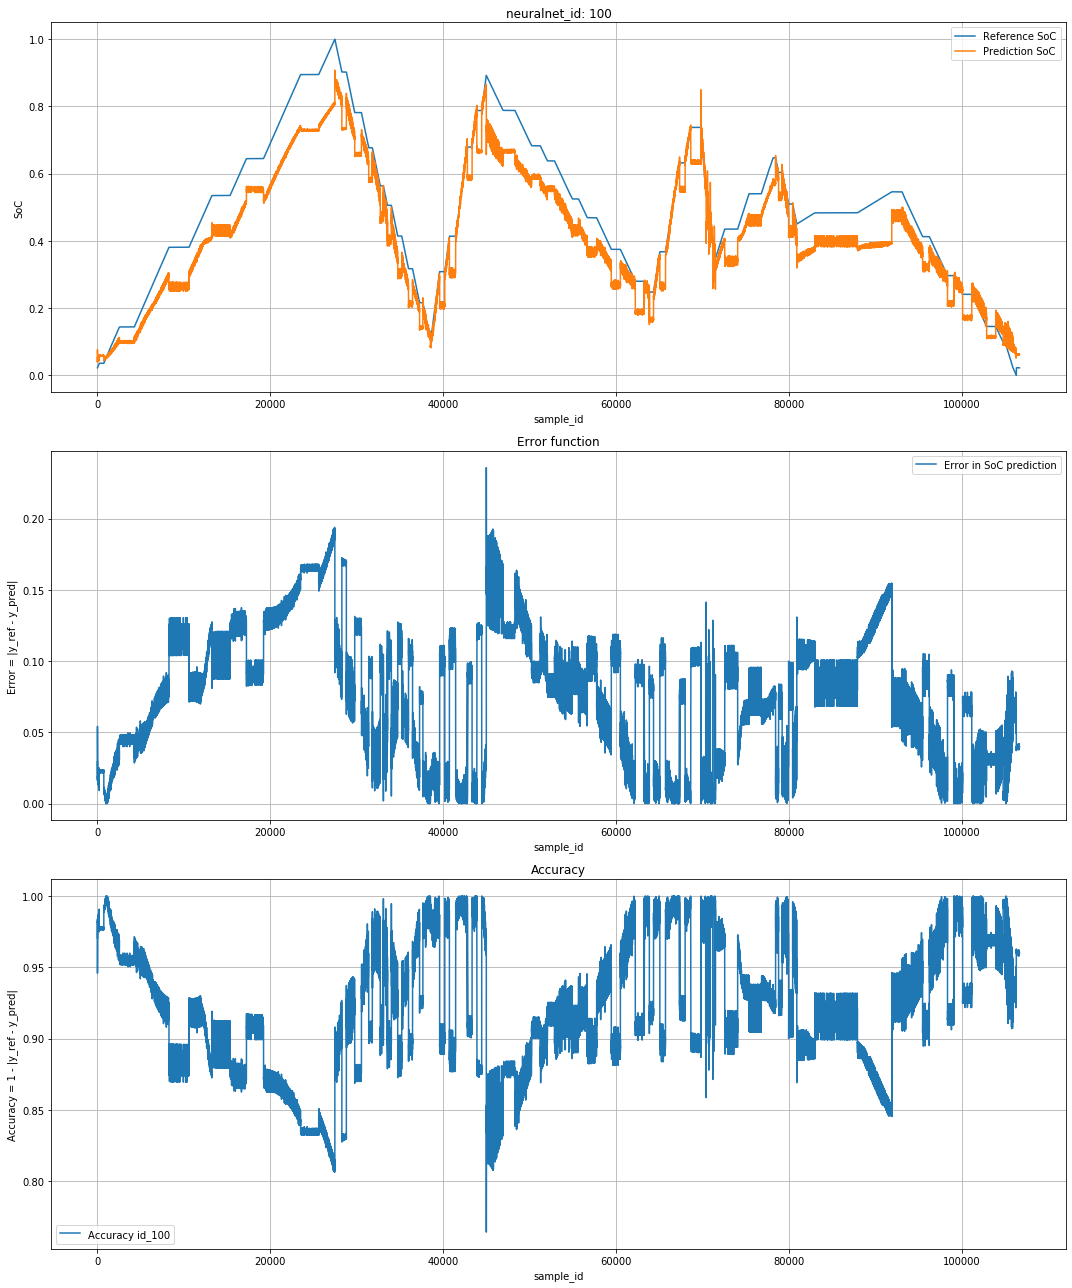

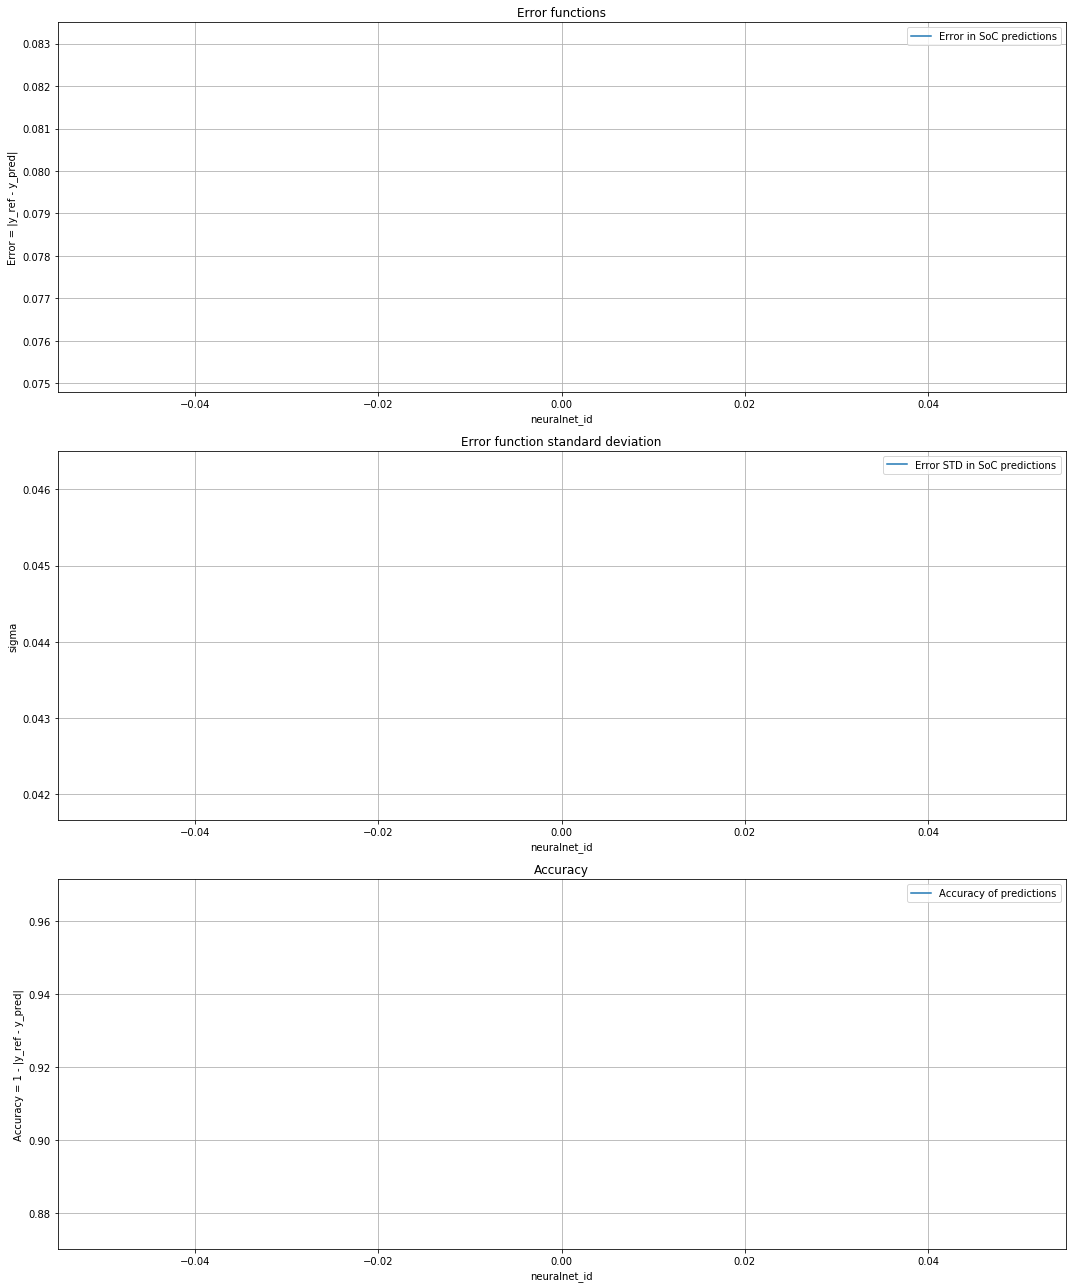

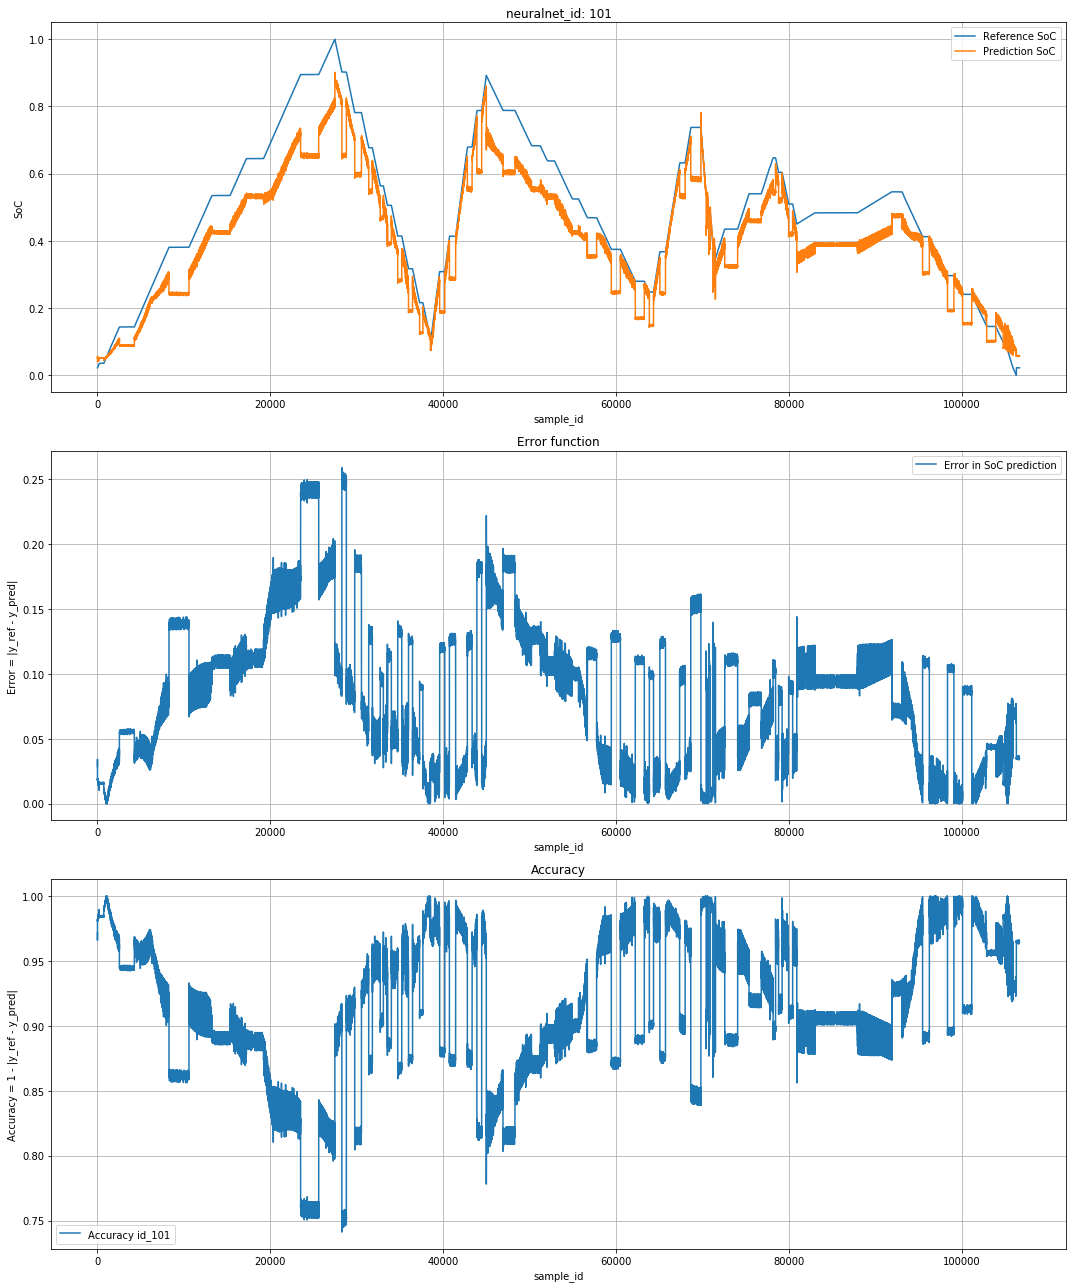

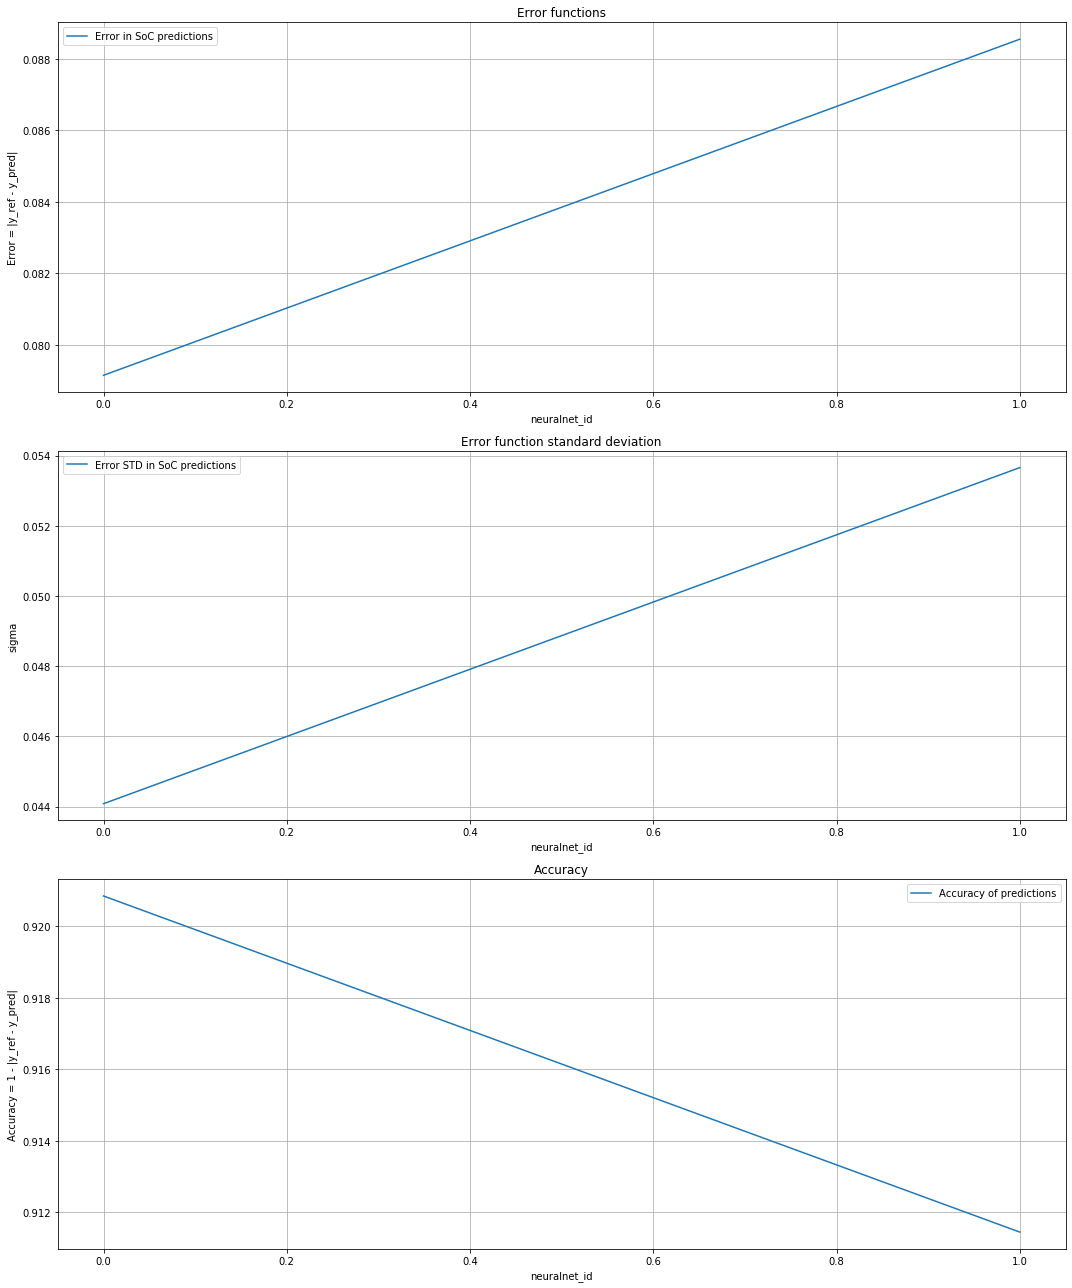

KeyboardInterrupt: 

In [4]:
optimizers = optimizer()
hidden_layer_size = [1, 2]
number_of_nodes = [[18, 12, 64], [36, 24, 24]]
batch_sizes = [1000, 500]
number_of_epochs = [50, 150, 250]

errors = []
accuracies = []
err_stds = []
names = []
cnt = 100

trend_performance = []
for i in range(len(data_sets)):
    for ls in range(len(hidden_layer_size)):
        for nn in range(len(number_of_nodes)):
            for ne in range(len(number_of_epochs)):
                for bs in range(len(batch_sizes)):
                    for o in range(len(optimizers)):
                        neural_net = soc_nn(data_sets[i],
                                            hidden_layer_size[ls],
                                            number_of_nodes[nn],
                                            number_of_epochs[ne],
                                            batch_sizes[bs],
                                            optimizers[o])

                        model = neural_net.run()

                        x_test = data_sets[i][2]
                        y_test = data_sets[i][3]

                        model_parameters = '_ls-{}_nn-{}_ne-{}_bs-{}_o-{}'.format(hidden_layer_size[ls],
                                                                                  number_of_nodes[nn][:ls+1],
                                                                                  number_of_epochs[ne],
                                                                                  batch_sizes[bs],
                                                                                  o + 1)
                        names.append(labels[i])
                        label = labels[i] + model_parameters
                        label = str(cnt) + '_' + label
                        print(label)

                        pred = model.predict(x_test, batch_size=batch_sizes[bs], verbose=0)
                        prediction = []
                        for j in range(len(pred)):
                            prediction.append(pred[j][0])

                        err = np.subtract(y_test, prediction)
                        error = np.absolute(err)
                        err_mean = np.mean(error)
                        err_std = np.std(error)
                        accuracies.append(1 - err_mean)
                        errors.append(err_mean)
                        err_stds.append(err_std)
                        print('Error: ', err_mean)
                        print('Accuracy: ', 1 - err_mean)
                        plot_run(error, y_test, prediction, label)

                        trend_performance.append([cnt,
                                                  names[cnt - 100],
                                                  hidden_layer_size[ls],
                                                  number_of_nodes[nn][:ls+1],
                                                  number_of_epochs[ne],
                                                  batch_sizes[bs],
                                                  errors[cnt - 100],
                                                  err_stds[cnt - 100],
                                                  accuracies[cnt - 100]])
                        cnt += 1

                        np.savetxt("trend_performance.csv", trend_performance, fmt="%s", delimiter=";")

                        plot_trend(errors, err_stds, accuracies, label.split('_')[0])

In [ ]:
np.savetxt("error.csv", errors, delimiter=",")
np.savetxt("err_std.csv", err_stds, delimiter=",")
np.savetxt("accuracy.csv", accuracies, delimiter=",")

